# Demo: synthetic experiments for spatio-temporal forecasting

This notebook generates synthetic datasets (univariate, spatial grid, sensor network), runs several baseline and library adapters via `app.model_runner.run_model`, and plots comparisons of real vs forecasted series. It also demonstrates a small CPU-only GCN training path when `train=True` is passed to the `torch_geometric` adapter.

## 1) Импорт библиотек

In [1]:
import os
import json
import math
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from io import StringIO

# local runner import
from app.model_runner import run_model

# directories
OUT_DIR = Path('outputs')
OUT_DIR.mkdir(exist_ok=True)
plt.rcParams['figure.figsize'] = (10,4)

## 2) Генерация синтетических пространственно-временных рядов

In [2]:
def generate_time_series(T=200, a=0.01, b=0.0, P=24, sigma=0.2, seed=0):
    rng = np.random.default_rng(seed)
    t = np.arange(T)
    trend = a * t + b
    season = np.sin(2 * np.pi * t / P)
    noise = rng.normal(scale=sigma, size=T)
    x = trend + season + noise
    return x

def generate_grid_evolution(T=100, H=16, W=16, diffusion=0.1, seed=1):
    rng = np.random.default_rng(seed)
    X = np.zeros((T, H, W), dtype=float)
    # initial hotspot
    cx, cy = H//2, W//2
    X[0, cx, cy] = 5.0
    for t in range(1, T):
        prev = X[t-1].copy()
        # simple diffusion + moving source
        lap = -4 * prev.copy()
        lap += np.roll(prev, 1, axis=0) + np.roll(prev, -1, axis=0) + np.roll(prev, 1, axis=1) + np.roll(prev, -1, axis=1)
        X[t] = prev + diffusion * lap + rng.normal(scale=0.05, size=(H, W))
        # moving source
        X[t, (cx + (t//10)) % H, (cy + (t//7)) % W] += 0.5
    return X

def generate_sensor_network(T=150, S=12, lag=1, rho=0.6, sigma=0.1, seed=2):
    rng = np.random.default_rng(seed)
    # random positions for sensors
    pos = rng.random((S,2))
    # adjacency by distance (k-nearest)
    from sklearn.neighbors import kneighbors_graph
    adj = kneighbors_graph(pos, n_neighbors=3, mode='connectivity', include_self=False).toarray()
    X = np.zeros((T, S), dtype=float)
    base = rng.normal(scale=0.5, size=S)
    for t in range(1, T):
        coupling = adj.dot(X[t-1]) / (adj.sum(axis=1) + 1e-6)
        X[t] = rho * X[t-1] + (1-rho) * coupling + 0.05 * rng.normal(size=S) + 0.1 * np.sin(2*np.pi*t/30 + rng.normal(scale=0.1, size=S))
    return X, pos, adj

# quick generate
uni = generate_time_series(T=250)
grid = generate_grid_evolution(T=120, H=16, W=16)
sensors, positions, adjacency = generate_sensor_network(T=200, S=16)

print('generated shapes:', uni.shape, grid.shape, sensors.shape)

generated shapes: (250,) (120, 16, 16) (200, 16)


## 3) Визуализация исходных данных

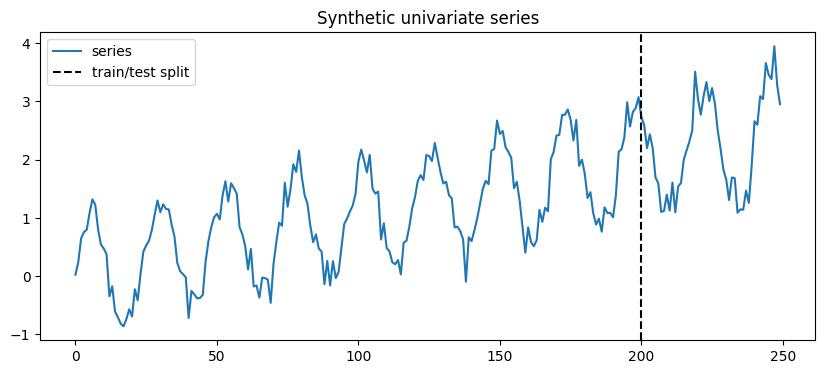

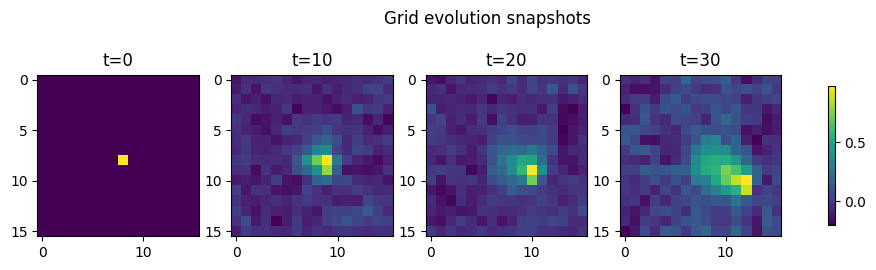

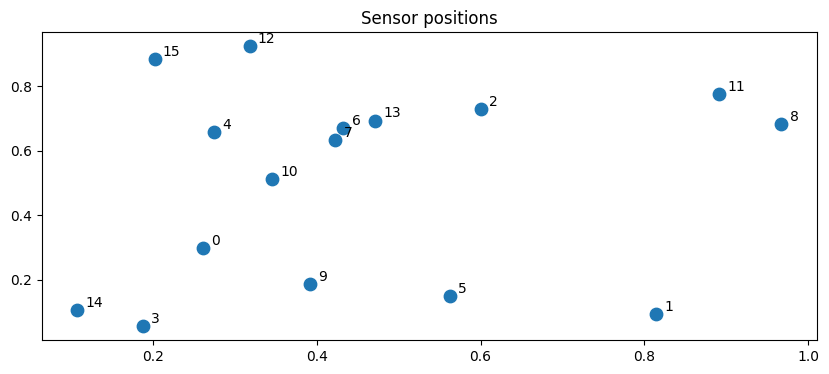

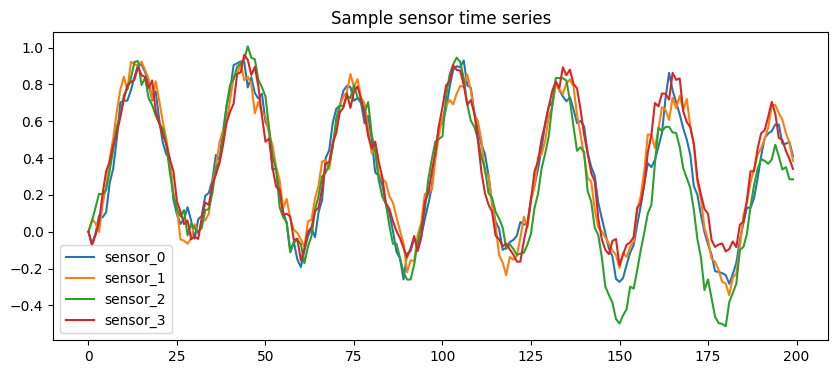

In [3]:
# 3.1 Univariate
T = len(uni)
train_cut = int(T*0.8)
plt.plot(uni, label='series')
plt.axvline(train_cut, color='k', ls='--', label='train/test split')
plt.legend(); plt.title('Synthetic univariate series')
plt.savefig(OUT_DIR / 'uni_series.png')
plt.show()

# 3.2 Grid example: show few timeframes
fig, axes = plt.subplots(1,4, figsize=(12,3))
for i, ax in enumerate(axes):
    t = i*10
    im = ax.imshow(grid[t], cmap='viridis')
    ax.set_title(f't={t}')
fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6)
plt.suptitle('Grid evolution snapshots')
plt.savefig(OUT_DIR / 'grid_snapshots.png')
plt.show()

# 3.3 Sensor network: plot sensor positions and a sample timeseries for first 4 sensors
plt.scatter(positions[:,0], positions[:,1], s=80, c='C0')
for i, (x,y) in enumerate(positions):
    plt.text(x+0.01, y+0.01, str(i))
plt.title('Sensor positions')
plt.savefig(OUT_DIR / 'sensor_positions.png')
plt.show()

plt.figure()
for i in range(4):
    plt.plot(sensors[:,i], label=f'sensor_{i}')
plt.legend(); plt.title('Sample sensor time series')
plt.savefig(OUT_DIR / 'sensor_timeseries.png')
plt.show()

## 4) Preprocessing / sliding window helper

In [4]:
def sliding_window(x, input_len=24, pred_horizon=3):
    # x: (T,) or (T, S) or (T, H, W) -> return arrays X: [N, input_len, ...], Y: [N, pred_horizon, ...]
    x = np.asarray(x)
    T = x.shape[0]
    outX, outY = [], []
    for i in range(0, T - input_len - pred_horizon + 1):
        xin = x[i:i+input_len]
        y = x[i+input_len:i+input_len+pred_horizon]
        outX.append(xin)
        outY.append(y)
    return np.stack(outX), np.stack(outY)

# StandardScaler usage example for 1D
def standardize_train_test(train, test):
    s = StandardScaler()
    s.fit(train.reshape(-1,1))
    return s.transform(train.reshape(-1,1)).ravel(), s.transform(test.reshape(-1,1)).ravel(), s

## 5) Baseline models: persistence and linear regression

In [5]:
def persistence_forecast(series, horizon):
    last = float(series[-1])
    return np.array([last + 0.0 for _ in range(horizon)])

def linreg_forecast(series, horizon, k=8):
    # use last k points as features to predict next 1..h recursively
    X = []
    y = []
    for i in range(k, len(series)):
        X.append(series[i-k:i])
        y.append(series[i])
    if len(X) == 0:
        return persistence_forecast(series, horizon)
    reg = LinearRegression().fit(np.array(X), np.array(y))
    preds = []
    state = series[-k:].copy().tolist()
    for h in range(horizon):
        p = reg.predict(np.array(state[-k:]).reshape(1,-1))[0]
        preds.append(p)
        state.append(p)
    return np.array(preds)

# quick baseline eval on univariate
h = 12
train = uni[:int(0.8*len(uni))]
test = uni[int(0.8*len(uni)):int(0.8*len(uni))+h]
p_pred = persistence_forecast(train, h)
l_pred = linreg_forecast(train, h)
print('baseline MAE persistence', mean_absolute_error(test, p_pred))
print('baseline MAE linreg', mean_absolute_error(test, l_pred))

baseline MAE persistence 1.2558486634275856
baseline MAE linreg 0.30884596049460217


## 6) LSTM for univariate series (compact runnable script)

In [6]:
# Compact LSTM example using PyTorch - runnable but kept small for demo
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, series, seq_len=24, horizon=1):
        self.series = np.asarray(series)
        self.seq_len = seq_len
        self.horizon = horizon
        self.X, self.Y = sliding_window(self.series, input_len=seq_len, pred_horizon=horizon)
        # X: [N, seq_len, ...] -> flatten features to 1D
        self.X = self.X.reshape(self.X.shape[0], self.X.shape[1], -1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        return torch.tensor(self.X[i], dtype=torch.float32), torch.tensor(self.Y[i].ravel(), dtype=torch.float32)

class SmallLSTM(nn.Module):
    def __init__(self, input_size=1, hidden=32, nlayers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden, nlayers, batch_first=True)
        self.head = nn.Linear(hidden, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.head(out[:, -1, :])

# small train to illustrate functionality (very short epochs for demo)
seq_len = 24
horizon = 12
train_series = uni[:int(0.8*len(uni))]
test_series = uni[int(0.8*len(uni)):int(0.8*len(uni))+horizon]
ds = SeqDataset(train_series, seq_len=seq_len, horizon=1)
loader = DataLoader(ds, batch_size=32, shuffle=True)
model = SmallLSTM(input_size=1, hidden=32)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
for epoch in range(3):
    total=0.0
    for xb, yb in loader:
        opt.zero_grad()
        p = model(xb)[:,0]
        loss = loss_fn(p, yb[:,0])
        loss.backward(); opt.step()
        total += float(loss.item())
    # print(f'epoch {epoch+1} loss {total:.4f}')
# recursive predict for horizon
state = train_series[-seq_len:].tolist()
preds_lstm = []
for _ in range(horizon):
    x_in = torch.tensor(np.array(state[-seq_len:]).reshape(1,seq_len,1), dtype=torch.float32)
    p = model(x_in).detach().numpy().ravel()[0]
    preds_lstm.append(p)
    state.append(p)
print('LSTM demo done')

LSTM demo done


## 7) ConvLSTM / simple spatio-temporal Conv+LSTM (compact demo)

In [7]:
# For brevity we implement a very small conv->lstm pipeline on flattened spatial maps
class ConvTimeModel(nn.Module):
    def __init__(self, H, W, hidden=64):
        super().__init__()
        self.conv = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.lstm = nn.LSTM(8*4*4, hidden, batch_first=True)
        self.head = nn.Linear(hidden, H*W)
    def forward(self, x):
        # x: [B, T, H, W] -> process each time with conv then LSTM over time
        B, T, H, W = x.shape
        feats = []
        for t in range(T):
            xi = x[:,t:t+1,:,:]
            f = torch.relu(self.conv(xi))
            f = self.pool(f)
            feats.append(f.reshape(B, -1))
        seq = torch.stack(feats, dim=1)
        out, _ = self.lstm(seq)
        return self.head(out[:,-1,:]).reshape(B, H, W)

# We skip a full training run here for brevity; the code above can be extended similar to LSTM block.
print('Conv+LSTM demo model defined')

Conv+LSTM demo model defined


## 8) Run adapter-backed forecasts and compare (sktime, tslearn, torch_geometric)

In [8]:
def parse_predictions_csv(pred_csv):
    # run_model adapters often return CSV text with columns horizon,node,forecast or similar
    try:
        if isinstance(pred_csv, tuple) or isinstance(pred_csv, list):
            # some adapters may return (code, csv)
            pred_csv = pred_csv[1]
        if isinstance(pred_csv, bytes):
            pred_csv = pred_csv.decode()
        df = pd.read_csv(StringIO(pred_csv))
        return df
    except Exception:
        # fallback: if already dataframe
        if isinstance(pred_csv, pd.DataFrame):
            return pred_csv
        raise

# 8.1 Univariate using sktime (AutoARIMA or Naive)
h = 12
train = uni[:int(0.8*len(uni))]
test_full = uni[int(0.8*len(uni)):int(0.8*len(uni))+h]
print('call sktime adapter... (may fallback if not installed)')
try:
    # pass raw array; run_model is expected to accept numpy arrays too
    out = run_model('sktime', train, horizon=h, model_args={'model_name': 'AutoARIMA'})
    df_out = parse_predictions_csv(out)
    # select horizon=1..h and node=0 if needed
    if 'horizon' in df_out.columns and 'forecast' in df_out.columns:
        preds = df_out.sort_values('horizon')['forecast'].values[:h]
    else:
        # try to coerce first column as forecast sequence
        preds = df_out.iloc[:, -1].values[:h]
except Exception as e:
    print('sktime adapter failed:', e)
    preds = persistence_forecast(train, h)

print('sktime preds head:', preds[:5])

# 8.2 Multivariate / grid: tslearn adapter - here we provide flattened per-node time series and plot mean forecast
# create per-node series from grid by averaging small patches (to keep shape manageable)
Tg, H, W = grid.shape
# collapse spatial dims to sensors by coarse pooling: 16 sensors
sensors_grid = grid.reshape(Tg, H*W)[:,:16]  # take first 16 cells as sensors for demo
train_g = sensors_grid[:int(0.8*Tg)]
h2 = 8
try:
    out2 = run_model('tslearn', train_g, horizon=h2, model_args={'n_neighbors':3, 'window_size':4})
    df2 = parse_predictions_csv(out2)
    # compute mean forecast across sensors for horizon 1..h2
    if set(['horizon','node','forecast']).issubset(df2.columns):
        mean_preds = df2.groupby('horizon')['forecast'].mean().reindex(range(1,h2+1)).values
    else:
        mean_preds = df2.iloc[:h2, -1].values
except Exception as e:
    print('tslearn adapter failed:', e)
    mean_preds = np.tile(persistence_forecast(train_g.mean(axis=1), h2) , 1)

# 8.3 Graph sensor network: use torch_geometric adapter with small training loop (train=True)
h3 = 10
train_s = sensors[:int(0.8*sensors.shape[0])]
# build edge_index in long format (2, E)
edges = []
S = sensors.shape[1]
for i in range(S):
    edges.append((i, (i+1)%S))
    edges.append(((i+1)%S, i))
edge_index = np.array(edges).T.astype(int)
try:
    out3 = run_model('torch_geometric', train_s, horizon=h3, edge_index=edge_index, train=True, model_args={'train': True, 'train_epochs': 8, 'lr':0.02})
    df3 = parse_predictions_csv(out3)
    # aggregate mean forecast across sensors
    if set(['horizon','node','forecast']).issubset(df3.columns):
        mean_preds_s = df3.groupby('horizon')['forecast'].mean().reindex(range(1,h3+1)).values
    else:
        mean_preds_s = df3.iloc[:h3, -1].values
except Exception as e:
    print('torch_geometric adapter failed:', e)
    mean_preds_s = persistence_forecast(train_s.mean(axis=1), h3)

print('adapter forecasts obtained')

call sktime adapter... (may fallback if not installed)


/home/sasha/llm-ida/.venv/lib/python3.12/site-packages/sktime/forecasting/naive/_naive.py:369: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_y = pd.concat([y_old, y_new], keys=["a", "b"]).sort_index(level=-1)


sktime preds head: [3.07319331 3.07319331 3.07319331 3.07319331 3.07319331]


/home/sasha/llm-ida/.venv/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


adapter forecasts obtained


## 9) Evaluation and plotting (MAE / RMSE)

true head [2.73331836 2.59442321 2.19897012 2.43468893 2.20122787]
sktime preds head [3.07319331 3.07319331 3.07319331 3.07319331 3.07319331]
lstm preds head [np.float32(0.32488006), np.float32(0.2639887), np.float32(0.2216157), np.float32(0.18581927), np.float32(0.15779184)]
persistence head [3.07319328 3.07319328 3.07319328 3.07319328 3.07319328]
linreg head [2.84770123 2.68292173 2.47502726 2.33587435 2.00069474]
sktime scores {'MAE': 1.2558486925235417, 'RMSE': 1.378365068222794}
lstm scores {'MAE': 1.6584839742212465, 'RMSE': 1.733359985607489}
persistence scores {'MAE': 1.2558486634275856, 'RMSE': 1.3783650417130402}
linreg scores {'MAE': 0.30884596049460217, 'RMSE': 0.4509941005171934}


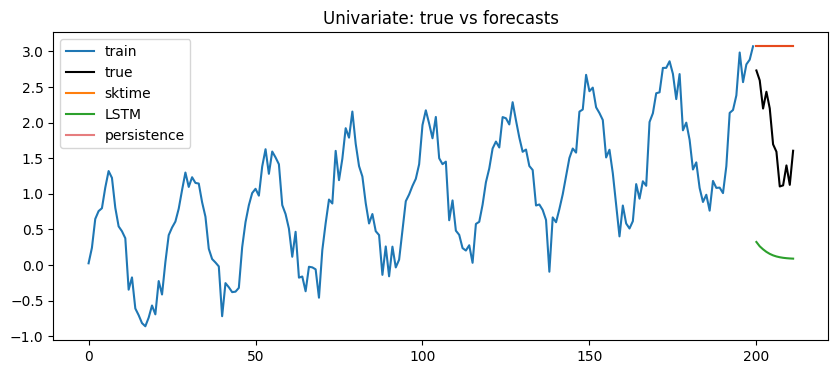

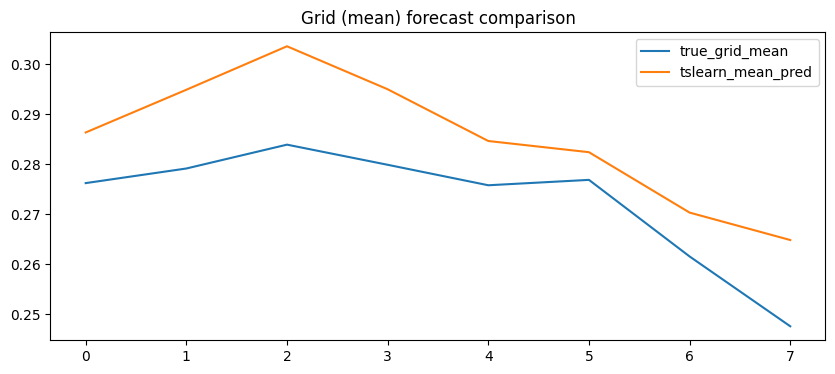

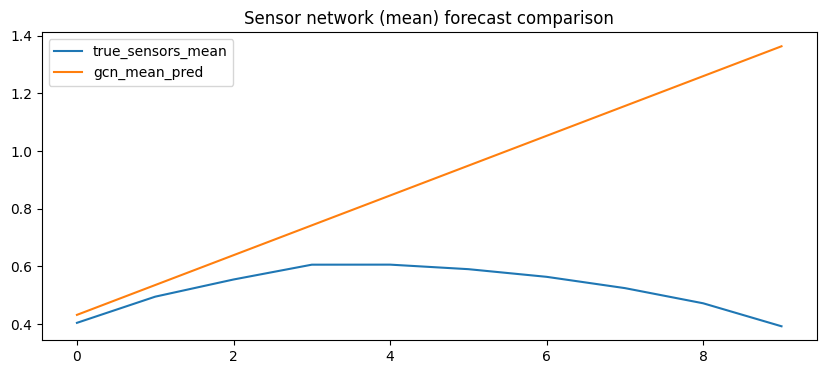

saved metrics and plots to outputs/


In [9]:
def scores(y_true, y_pred):
    return {'MAE': float(mean_absolute_error(y_true, y_pred)), 'RMSE': float(math.sqrt(mean_squared_error(y_true, y_pred)))}

# univariate compare
true_uni = test_full[:h]
print('true head', true_uni[:5])
print('sktime preds head', preds[:5])
print('lstm preds head', preds_lstm[:5])
print('persistence head', p_pred[:5])
print('linreg head', l_pred[:5])

print('sktime scores', scores(true_uni, preds))
print('lstm scores', scores(true_uni, preds_lstm))
print('persistence scores', scores(true_uni, p_pred))
print('linreg scores', scores(true_uni, l_pred))

# plot univariate comparison
plt.figure()
t_index = np.arange(len(train), len(train)+h)
plt.plot(np.arange(len(train)), train, label='train')
plt.plot(t_index, true_uni, label='true', color='k')
plt.plot(t_index, preds, label='sktime')
plt.plot(t_index, preds_lstm, label='LSTM')
plt.plot(t_index, p_pred, label='persistence', alpha=0.6)
plt.legend(); plt.title('Univariate: true vs forecasts')
plt.savefig(OUT_DIR / 'uni_compare.png')
plt.show()

# plot mean forecasts for grid and sensors
plt.figure();
# true future mean of taken cells for grid
true_grid_mean = sensors_grid.mean(axis=1)[int(0.8*Tg):int(0.8*Tg)+h2]
plt.plot(true_grid_mean, label='true_grid_mean')
plt.plot(np.arange(len(true_grid_mean)), mean_preds, label='tslearn_mean_pred')
plt.legend(); plt.title('Grid (mean) forecast comparison'); plt.savefig(OUT_DIR / 'grid_mean_compare.png'); plt.show()

plt.figure();
true_sensors_mean = sensors.mean(axis=1)[int(0.8*sensors.shape[0]):int(0.8*sensors.shape[0])+h3]
plt.plot(true_sensors_mean, label='true_sensors_mean')
plt.plot(np.arange(len(true_sensors_mean)), mean_preds_s, label='gcn_mean_pred')
plt.legend(); plt.title('Sensor network (mean) forecast comparison'); plt.savefig(OUT_DIR / 'sensors_mean_compare.png'); plt.show()

# save metrics to JSON
metrics = {
    'univariate': scores(true_uni, preds),
    'lstm': scores(true_uni, preds_lstm),
    'persistence': scores(true_uni, p_pred)
}
with open(OUT_DIR / 'metrics.json', 'w') as f:
    json.dump(metrics, f, indent=2)
print('saved metrics and plots to outputs/')

## 10) Run notebook as script / VSCode instructions

To run the notebook headlessly from terminal: 

```
jupyter nbconvert --to notebook --execute notebooks/demo_experiments.ipynb --ExecutePreprocessor.timeout=600
```
Or open in VSCode and execute cell-by-cell. Outputs and PNGs will be saved into `outputs/`.

## 11) Saving models and artifacts
Examples:

```
torch.save(model.state_dict(), 'models/lstm_small.pth')
joblib.dump(scaler, 'models/scaler.pkl')
```
: {
: {
: 
3
,
: 
,
: 

: {
: 
,
: 
3.12

: 4,
: 5